In [6]:
import pandas as pd

sales_with_rarity = pd.read_csv('sales_with_rarity.csv')

days = 1

# Convert the 'timestamp' from Unix epoch to datetime
sales_with_rarity['date'] = pd.to_datetime(sales_with_rarity['timestamp'], unit='ns').dt.date

sales_with_rarity['price'] = sales_with_rarity['price']/1000000
# Group by 'collection' and 'date' to find the minimum price (floor price) for each day
floor_prices = sales_with_rarity.groupby(['collection', 'date'])['price'].min().reset_index()

# Rename the 'price' column to 'floor_price' in the floor_prices DataFrame
floor_prices.rename(columns={'price': 'floor_price'}, inplace=True)

# Calculate the 7-day rolling average of the floor prices for each collection
floor_prices[f'{days}_day_rolling_avg_floor_price'] = floor_prices.groupby('collection')['floor_price'].transform(lambda x: x.rolling(window=days).mean())

# Merge the 7-day rolling average floor price back into the original DataFrame
sales_with_rarity = pd.merge(sales_with_rarity, floor_prices[['collection', 'date', f'{days}_day_rolling_avg_floor_price']], on=['collection', 'date'], how='left')
sales_with_rarity['times_above_floor'] = (sales_with_rarity.price/(sales_with_rarity[f'{days}_day_rolling_avg_floor_price']))

<Axes: >

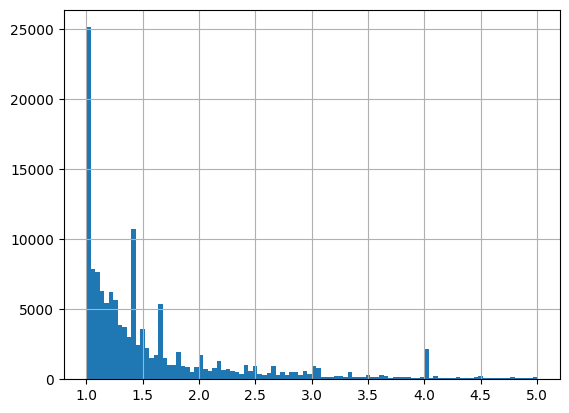

In [5]:
res = (sales_with_rarity.price/(sales_with_rarity[f'{days}_day_rolling_avg_floor_price']))
res[res<5].hist(bins=100)

In [191]:
sales_with_rarity.times_above_floor.mean(), sales_with_rarity.times_above_floor.median()

(5.708349407592034, 1.4285714285714286)

In [7]:
for col in sales_with_rarity.collection.unique():
    sales = sales_with_rarity[sales_with_rarity.collection ==col]
    print(col, len(sales), round(sales.times_above_floor.mean(),2), round(sales.times_above_floor.median(),2))

zvycl-fyaaa-aaaah-qckmq-cai 19360 3.38 1.49
rw7qm-eiaaa-aaaak-aaiqq-cai 16294 2.38 1.26
3bqt5-gyaaa-aaaah-qcvha-cai 10448 11.51 2.72
4ggk4-mqaaa-aaaae-qad6q-cai 1616 2.06 1.08
pk6rk-6aaaa-aaaae-qaazq-cai 9480 2.11 1.67
bxdf4-baaaa-aaaah-qaruq-cai 11126 9.42 1.5
skjpp-haaaa-aaaae-qac7q-cai 21320 2.16 1.43
rw623-hyaaa-aaaah-qctcq-cai 1962 2.99 1.18
bzsui-sqaaa-aaaah-qce2a-cai 21878 8.39 1.4
ugdkf-taaaa-aaaak-acoia-cai 760 1.32 1.1
dhiaa-ryaaa-aaaae-qabva-cai 1063 1.56 1.06
s36wu-5qaaa-aaaah-qcyzq-cai 4605 2.41 1.1
5movr-diaaa-aaaak-aaftq-cai 10354 2.57 1.38
oeee4-qaaaa-aaaak-qaaeq-cai 8170 27.0 1.87
txr2a-fqaaa-aaaah-qcmkq-cai 5648 1.67 1.18
3mttv-dqaaa-aaaah-qcn6q-cai 15565 3.4 1.69


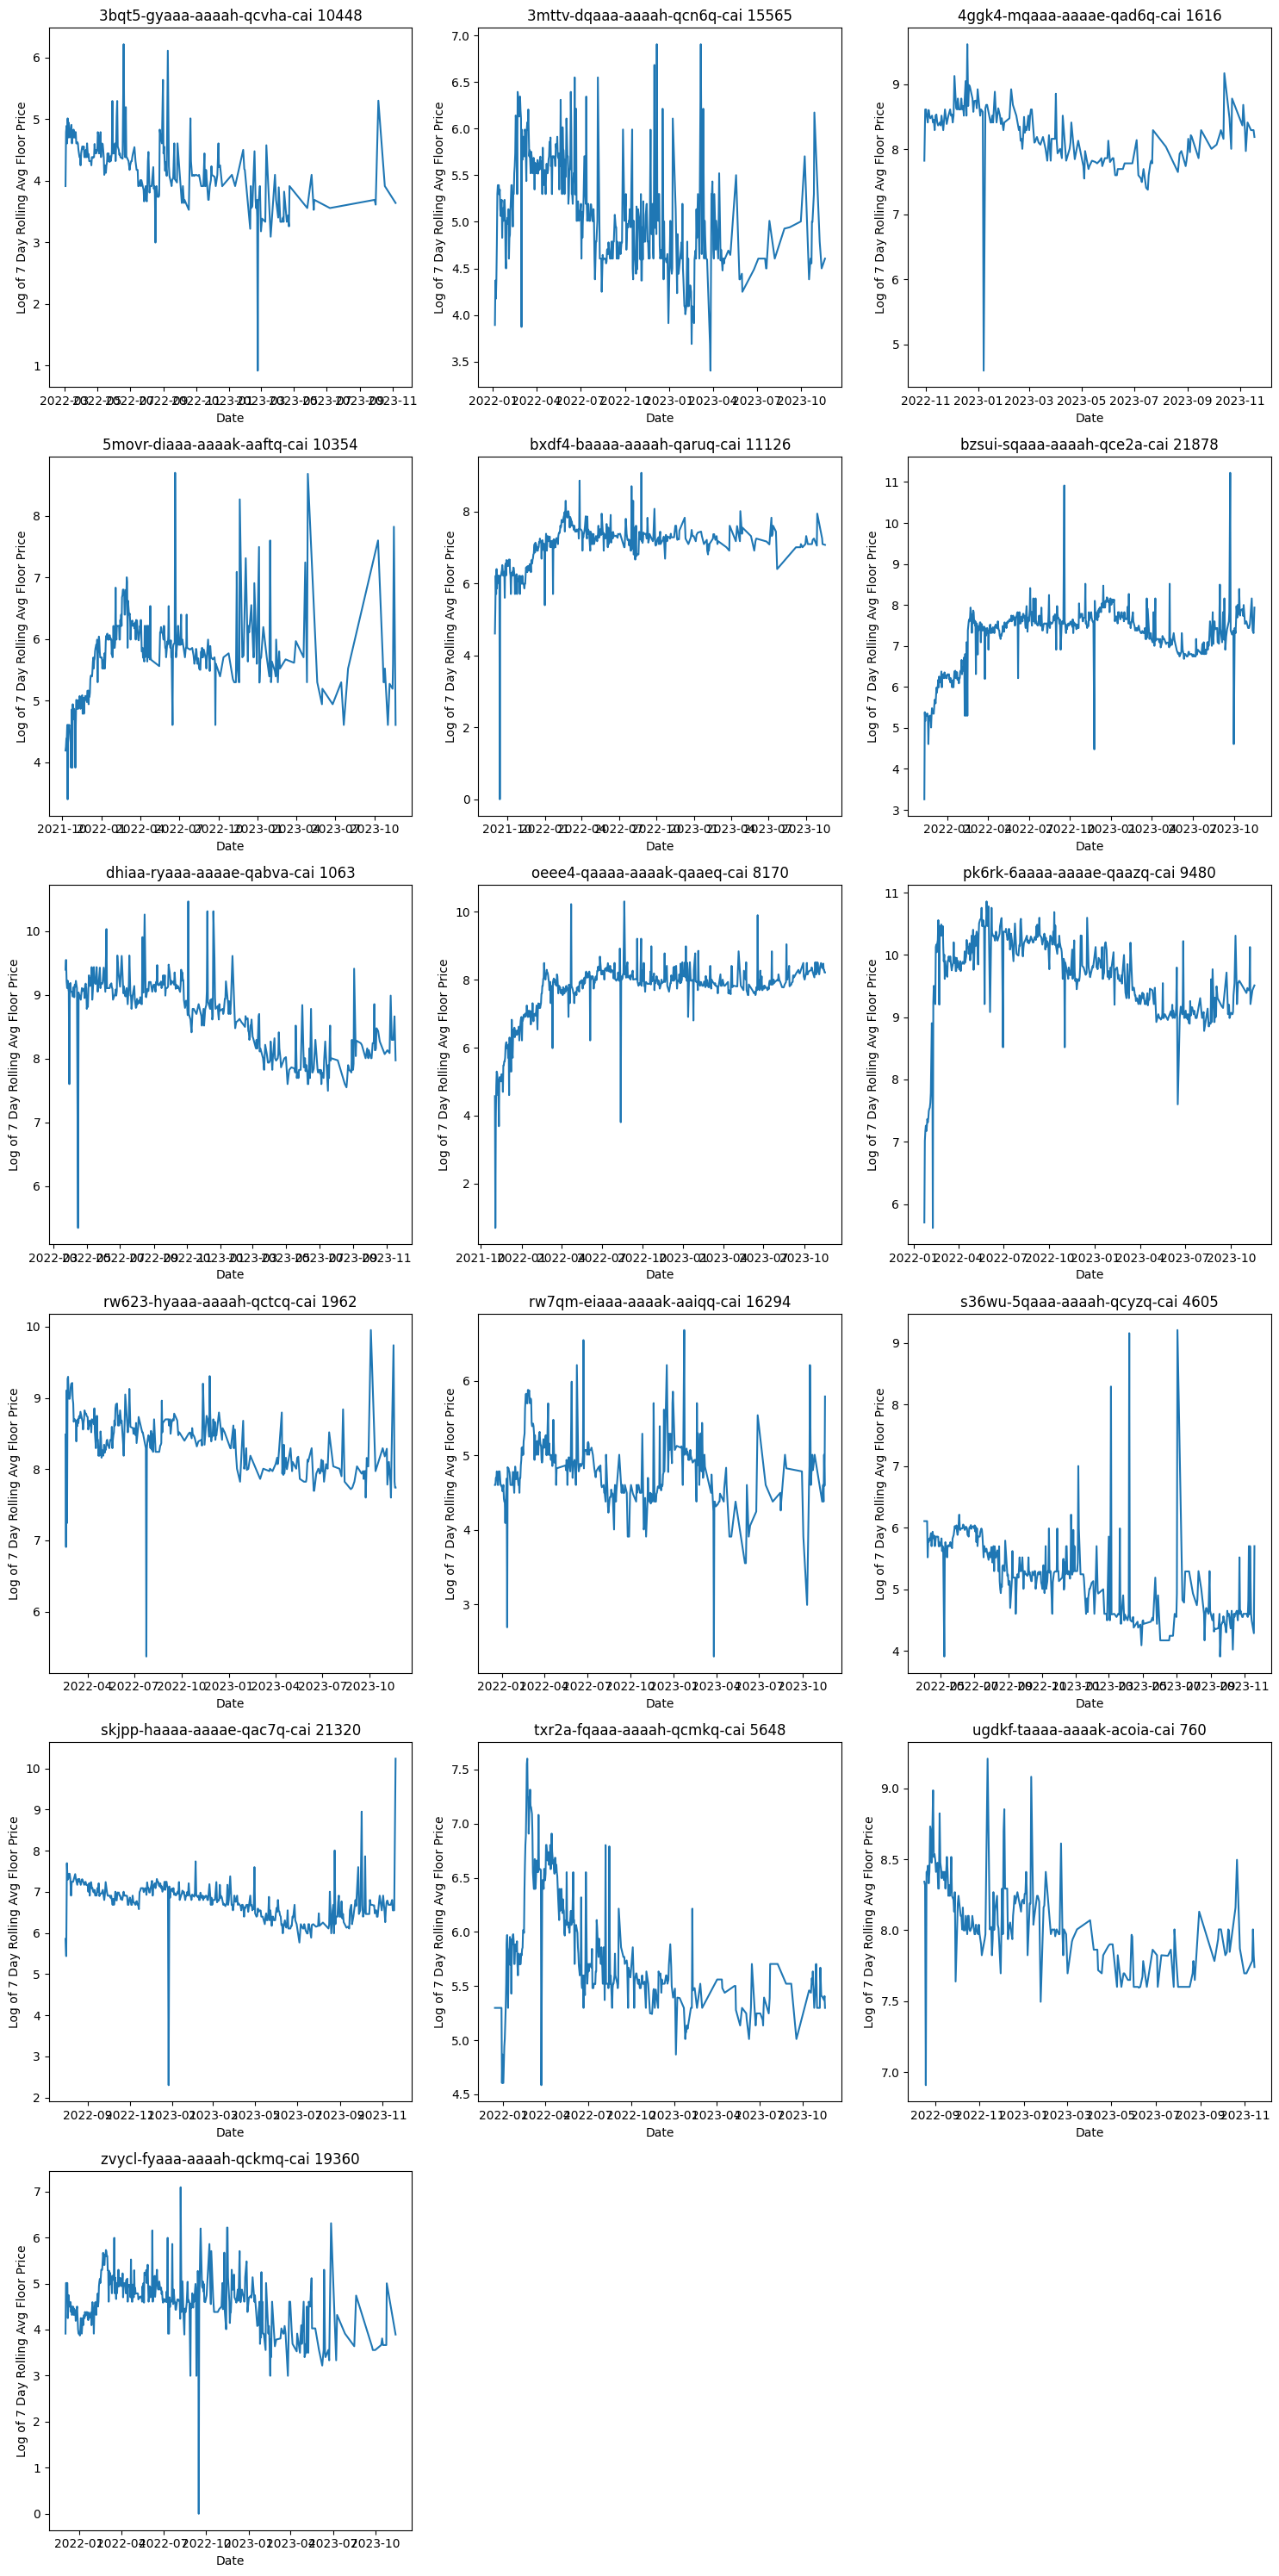

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming `floor_prices` is your DataFrame
collections = floor_prices['collection'].unique()
num_collections = len(collections)

# Determine grid size
cols = 3
rows = (num_collections // cols) + (num_collections % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for idx, collection in enumerate(collections):
    ax = axes[idx]
    collection_data = floor_prices[floor_prices['collection'] == collection].set_index('date')[f'{days}_day_rolling_avg_floor_price']
    ax.plot(np.log(collection_data))
    ax.set_title(collection + ' '+str(len(sales_with_rarity[sales_with_rarity.collection ==collection])))
    ax.set_xlabel('Date')
    ax.set_ylabel('Log of 7 Day Rolling Avg Floor Price')

# Remove any empty subplots
for i in range(num_collections, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


rw623-hyaaa-aaaah-qctcq-cai
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

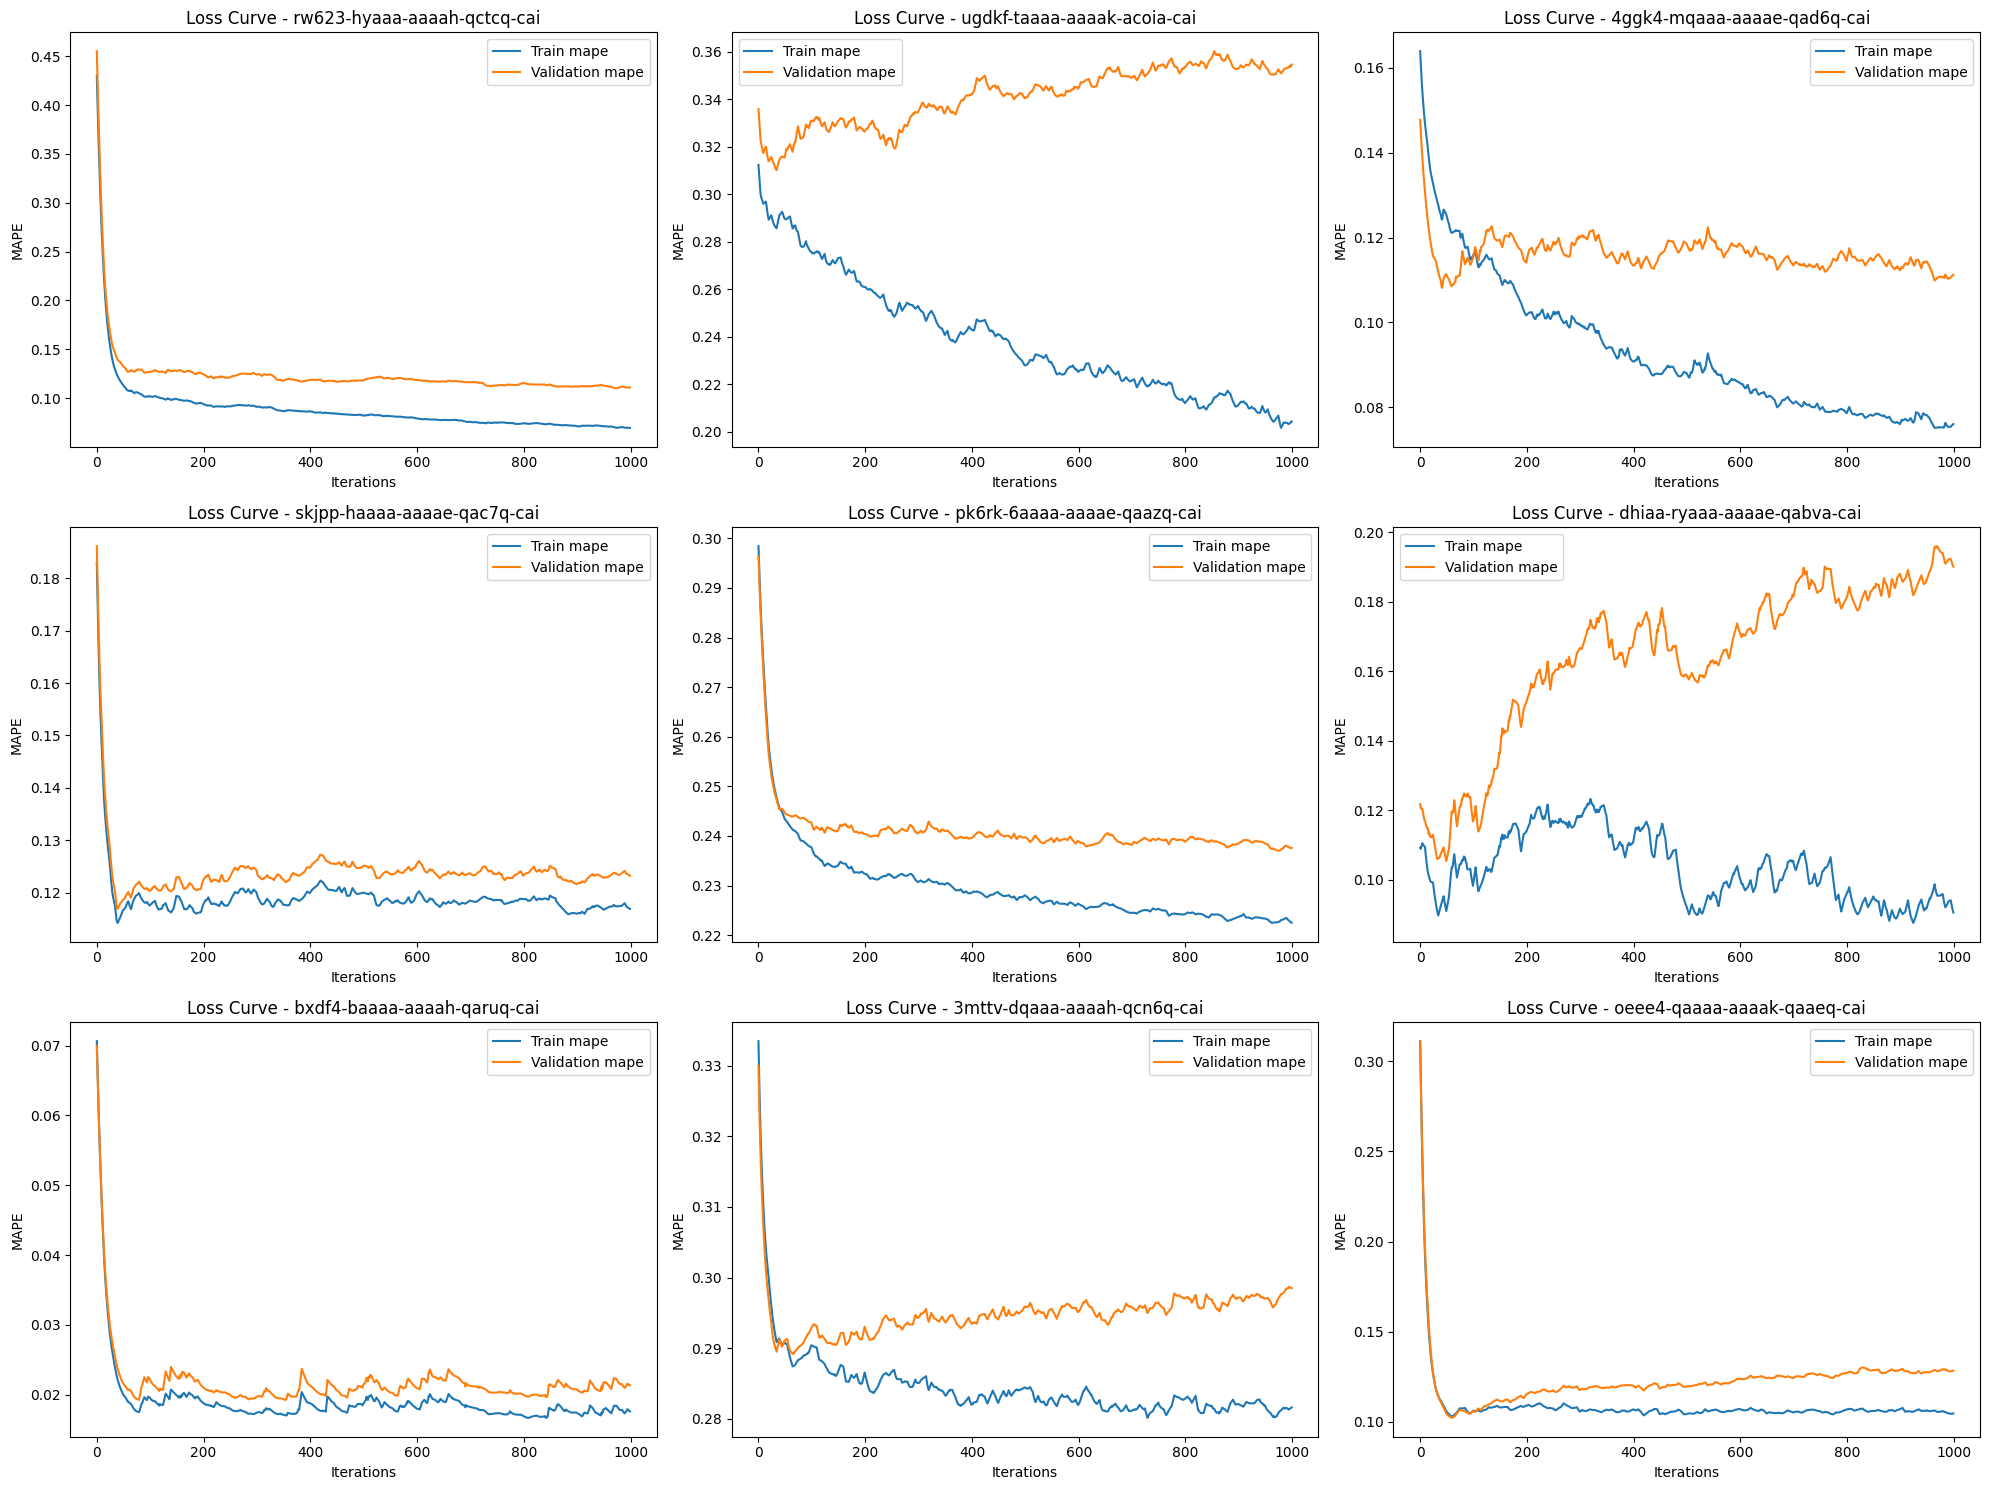

54.82567242625439

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

def plot_results(sales_with_rarity, days):
    results = {}
    # unique_collections = sales_with_rarity.collection.unique()
    unique_collections = ['rw623-hyaaa-aaaah-qctcq-cai', # og medals
    'ugdkf-taaaa-aaaak-acoia-cai', # mokoto mesh
    '4ggk4-mqaaa-aaaae-qad6q-cai', #icp flower
    'skjpp-haaaa-aaaae-qac7q-cai', # Pineapple Punks
    'pk6rk-6aaaa-aaaae-qaazq-cai', # btc flower 
    'dhiaa-ryaaa-aaaae-qabva-cai', # eth flower
    'bxdf4-baaaa-aaaah-qaruq-cai', # icpunks
    '3mttv-dqaaa-aaaah-qcn6q-cai', # Dfinity Space Apes
    'oeee4-qaaaa-aaaak-qaaeq-cai'] #Motoko Ghosts
    num_collections = len(unique_collections)
    
    fig, axes = plt.subplots(nrows=(num_collections + 2) // 3, ncols=3, figsize=(20, num_collections * 5 // 3))
    axes = axes.flatten()

    for idx, col in enumerate(unique_collections):
        sales = sales_with_rarity[sales_with_rarity.collection == col]
        print(col)
        training_data = sales.copy()
        X = training_data[['rank', f'{days}_day_rolling_avg_floor_price']].values
        y = training_data['times_above_floor'].values

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Scale the data
        scaler_X = StandardScaler()
        X_train = scaler_X.fit_transform(X_train)
        X_test = scaler_X.transform(X_test)

        scaler_y = StandardScaler()
        y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
        y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

        # Create the LightGBM dataset
        train_data = lgb.Dataset(X_train, label=y_train)
        test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

        # Set parameters for LightGBM
        params = {
      'objective': 'regression',
      'metric': 'mape',
      'boosting_type': 'gbdt',
      'learning_rate': 0.05,  # Reduced learning rate
      # 'num_leaves': 15,  # Reduced number of leaves
      'feature_fraction': 0.8,  # Slightly reduced feature fraction
      'bagging_fraction': 0.7,  # Slightly reduced bagging fraction
      'bagging_freq': 5,
      'min_data_in_leaf': 20,  # Minimum number of data in one leaf
      'reg_alpha': 0.1,  # L1 regularization term
      'reg_lambda': 0.1,  # L2 regularization term
      'verbose': 0
  }


        # Dictionary to hold evaluation results
        evals_result = {}

        # Train the model
        model = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[train_data, test_data], callbacks=[lgb.record_evaluation(evals_result)])

        # Plot the loss curve
        axes[idx].plot(evals_result['training']['mape'], label='Train mape')
        axes[idx].plot(evals_result['valid_1']['mape'], label='Validation mape')
        axes[idx].set_xlabel('Iterations')
        axes[idx].set_ylabel('MAPE')
        axes[idx].set_title(f'Loss Curve - {col}')
        axes[idx].legend()

        # Make predictions
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)

        # Inverse transform the predictions and the actual values to original scale
        y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

        # Calculate MAPE
        mape = mean_absolute_percentage_error(y_test, y_pred)
        print(f"MAPE for {col}: {mape}")
        results[col] = mape

    # Hide any unused subplots
    for idx in range(num_collections, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

    return results

results = plot_results(sales_with_rarity, 1)
(pd.DataFrame([results]).T.sort_values(by =0)*100).median().values[0]

rw623-hyaaa-aaaah-qctcq-cai
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

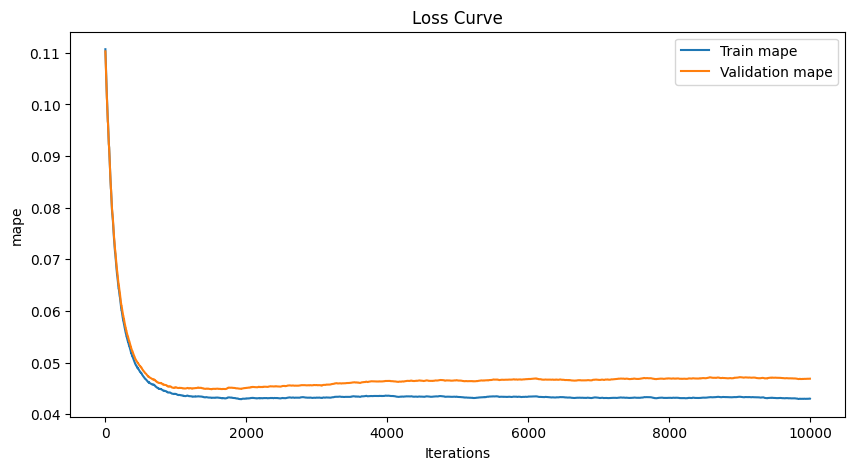

mape: 0.8276121760333516 0.35


In [26]:
results = {}
# for col in sales_with_rarity.collection.unique():
collection_names  = [
    
    'rw623-hyaaa-aaaah-qctcq-cai', # og medals
    'ugdkf-taaaa-aaaak-acoia-cai', # mokoto mesh
    '4ggk4-mqaaa-aaaae-qad6q-cai', #icp flower
    'skjpp-haaaa-aaaae-qac7q-cai', # Pineapple Punks
    'pk6rk-6aaaa-aaaae-qaazq-cai', # btc flower 
    'dhiaa-ryaaa-aaaae-qabva-cai', # eth flower
    'bxdf4-baaaa-aaaah-qaruq-cai', # icpunks
    '3mttv-dqaaa-aaaah-qcn6q-cai', # Dfinity Space Apes
    'oeee4-qaaaa-aaaak-qaaeq-cai'] #Motoko Ghosts
import pandas as pd

# Assuming sales is your DataFrame and sales.collection is the column you want to convert to dummy variables
sales = sales_with_rarity[sales_with_rarity.collection.isin(collection_names)]
# Create dummy variables
sales_dummies = pd.get_dummies(sales['collection'])

# Concatenate the dummy variables with the original DataFrame
sales = pd.concat([sales, sales_dummies], axis=1)

# Drop the original collection column if it's no longer needed
sales.drop('collection', axis=1, inplace=True)

# Display the updated DataFrame
sales

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
import lightgbm as lgb

# Assuming sales_with_rarity is your DataFrame
print(col)
training_data = sales.copy()
X = training_data[['rank', f'{days}_day_rolling_avg_floor_price']+collection_names].values
y = training_data['times_above_floor'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Create the LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'mape',
    'boosting_type': 'gbdt',
    'learning_rate': 0.005,  # Reduced learning rate
    'num_leaves': 31,  # Reduced number of leaves
    'feature_fraction': 0.8,  # Slightly reduced feature fraction
    'bagging_fraction': 0.7,  # Slightly reduced bagging fraction
    'bagging_freq': 5,
    'min_data_in_leaf': 10,  # Minimum number of data in one leaf
    'reg_alpha': 0.1,  # L1 regularization term
    'reg_lambda': 0.3,  # L2 regularization term
    'verbose': 0
}

# Dictionary to hold evaluation results
evals_result = {}

# Train the model
model = lgb.train(params, train_data, num_boost_round=10000, valid_sets=[train_data, test_data], callbacks=[lgb.record_evaluation(evals_result)])

# Plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(evals_result['training']['mape'], label='Train mape')
plt.plot(evals_result['valid_1']['mape'], label='Validation mape')
plt.xlabel('Iterations')
plt.ylabel('mape')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Make predictions
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Inverse transform the predictions and the actual values to original scale
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calculate mape
mape = np.sqrt(mean_absolute_percentage_error(y_test, y_pred))
x = pd.DataFrame()
x['y_pred'] = y_pred
x['y_test'] = y_test
median_error= (((x.y_pred/x.y_test)-1).abs()).median()

print(f"mape: {mape}", round(median_error,2))
results[col] = round(median_error,2)

x['error'] = ((x.y_pred/x.y_test)-1)*100
x[x['error'].abs()<x['error'].abs().quantile(0.95)].error.hist(bins=1000)

In [116]:
all_rarity_scores.to_json('all_rarity_scores.json', orient='records')


In [ ]:
import tensorflow as tf
from tensorflow import keras
import tf2onnx  # For ONNX conversion
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

results = {}
collection_names  = [
    'rw623-hyaaa-aaaah-qctcq-cai', # og medals
    'ugdkf-taaaa-aaaak-acoia-cai', # mokoto mesh
    '4ggk4-mqaaa-aaaae-qad6q-cai', #icp flower
    'skjpp-haaaa-aaaae-qac7q-cai', # Pineapple Punks
    'pk6rk-6aaaa-aaaae-qaazq-cai', # btc flower 
    'dhiaa-ryaaa-aaaae-qabva-cai', # eth flower
    'bxdf4-baaaa-aaaah-qaruq-cai', # icpunks
    '3mttv-dqaaa-aaaah-qcn6q-cai', # Dfinity Space Apes
    'oeee4-qaaaa-aaaak-qaaeq-cai'] #Motoko Ghosts


import pandas as pd

sales = sales_with_rarity[sales_with_rarity.collection.isin(collection_names)]
sales_dummies = pd.get_dummies(sales['collection'])
sales = pd.concat([sales, sales_dummies], axis=1)
sales.drop('collection', axis=1, inplace=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
import lightgbm as lgb

# Assuming sales_with_rarity is your DataFrame
print(col)
training_data = sales.copy()
X = training_data[['rank', f'{days}_day_rolling_avg_floor_price']+collection_names].values
y = training_data['times_above_floor'].values

# Split the data

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Scale the data
# scaler_X = StandardScaler()
# X_train = scaler_X.fit_transform(X_train)
# X_test = scaler_X.transform(X_test)

# scaler_y = StandardScaler()
# y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
# y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Build the improved TensorFlow Model
model = keras.Sequential([
    keras.layers.Dense(1024, input_shape=[X.shape[1]], activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])


# Compile the model with a different optimizer and learning rate
# optimizer = 

# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001), loss='mean_squared_error')


# Adding Early Stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stop], verbose=0)

# Plotting the training loss curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions and the actual values to original scale
y_pred = scaler_y.inverse_transform(y_pred).flatten()
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")
x = pd.DataFrame()
x['y_pred'] = y_pred
x['y_test'] = y_test
x['error'] = ((x.y_pred/x.y_test)-1)*100
print(x['error'].abs().median())
x[x['error'].abs()<x['error'].abs().quantile(0.95)].error.hist(bins=1000)


# Convert the Model to ONNX
# Define input and output names for ONNX
# input_signature = [tf.TensorSpec((None, 2), tf.float32, name='input')]
# output_signature = [tf.TensorSpec((None, 1), tf.float32, name='output')]

# model_proto, _ = tf2onnx.convert.from_keras(model, input_signature, output_signature)
# with open("model.onnx", "wb") as f:
#     f.write(model_proto.SerializeToString())


Trial 3 Complete [00h 00m 11s]
val_loss: 2157.282958984375

Best val_loss So Far: 2157.282958984375
Total elapsed time: 00h 00m 33s
Epoch 1/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 1s 428us/step - loss: 187808.2969 - mean_squared_error: 187808.2969
Epoch 2/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step - loss: 4305.8374 - mean_squared_error: 4305.8374
Epoch 3/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step - loss: 2212.3640 - mean_squared_error: 2212.3640
Epoch 4/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 1s 446us/step - loss: 2139.4946 - mean_squared_error: 2139.4946
Epoch 5/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step - loss: 2128.6033 - mean_squared_error: 2128.6033
Epoch 6/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step - loss: 2071.6470 - mean_squared_error: 2071.6470
Epoch 7/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 1s 333us/step - loss: 2002.9011 - mean_squared_error: 2002.9011
Epoch 8/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 1s 343us/step - loss: 1850.8589 - mean_squared_error: 1850.8589
Epoch 9/10
1777/

/opt/homebrew/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 11421786.0000 - mean_squared_error: 11421786.0000
Test Loss: [10563944.0, 10563944.0]
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step
RMSE: 3250.2212486439885
42.2951286449949


<Axes: >

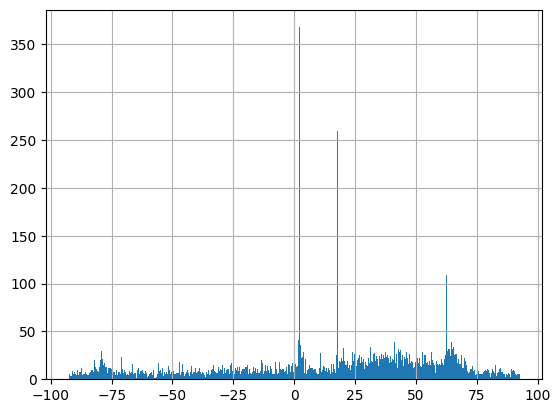

In [63]:
import autokeras as ak

input_node = ak.Input()
output_node = input_node
output_node = ak.DenseBlock()(output_node)
output_node = ak.RegressionHead()(output_node)
regressor = ak.AutoModel(
    inputs=input_node,
    outputs=output_node,
    overwrite=True,  # Overwrite previous results if they exist
    max_trials=3,  # Number of different models to try (adjust as needed)
)

# Search for the best model (this will take time)
regressor.fit(X_train,
               y_train, 
                batch_size=32,
                epochs=10,
                    # validation_split=0.2,
)  # Set 'epochs' to a suitable value

# Evaluate the best model
loss = regressor.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Get the best model
best_model = regressor.export_model()

y_pred = best_model.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")
y_pred = scaler_y.inverse_transform(y_pred).flatten()

x = pd.DataFrame()
x['y_pred'] = y_pred
x['y_test'] = y_test
x['error'] = ((x.y_pred/x.y_test)-1)*100
print(x['error'].abs().median())
x[x['error'].abs()<x['error'].abs().quantile(0.95)].error.hist(bins=1000)



In [93]:
import tensorflow as tf
import tf2onnx

# Adjust the input and output signatures to match your model
input_shape = best_model.inputs[0].shape[1]
output_shape = best_model.outputs[0].shape[1]

input_signature = [tf.TensorSpec((None, input_shape), tf.float32, name='input')]
output_signature = [tf.TensorSpec((None, output_shape), tf.float32, name='output')]

best_model.output_names = ['output']

# Export to ONNX
onnx_model, _ = tf2onnx.convert.from_keras(best_model, input_signature, opset=13)
with open("complex_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())